In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import statsmodels.formula.api as smf
from sklearn import linear_model, cross_validation
import scipy.stats as prr

## Regression Class

In [72]:
class Regression:
    def __init__(self, pathToData):
        self.data = pd.read_csv(pathToData, index_col=0)

    def getDataFrame(self):
        return self.data

    
    
    # get collinearity (r^2 value) of a pair of columns
    def getCollinearityScore(self, dependentCol, independentCol):
        array = self.data.values
        X = array[:, independentCol]
        Y = array[:, dependentCol]

        return prr.pearsonr(X, Y)
        # GET SUBTABLE CONTAINING ONLY THE INDEPENDENT COLUMN AND DEPENDENT COLUMN
        # df2 = self.data.iloc[:, [independentCol, dependentCol]]
        # CREATE FITTED MODEL USING ORDINARY LEAST SQUARES REGRESSION
        # lm = smf.ols(formula='Sales ~ TV', data=df2).fit()
        # RETURN RSQUARED VALUE FOR THE MODEL
        # return lm.rsquared

    # print collinearities (r^2 value) of each pair of columns
    def printAllCollinearities(self):
        array = self.data.values
        length_col = self.data.shape[1]
        while(0 != length_col-1):
            for x in range(0, length_col-1):
                X = array[:, x]
                Y = array[:, length_col-1]

                print("Collinearity between "+self.data.columns.values[x]+" & "+self.data.columns.values[length_col-1]+" = "+str(prr.pearsonr(X, Y)))
            length_col -= 1

    def getSubTable(self, col_names):
        array = self.data
        return array.loc[:, col_names]
            
    def getFittedRegressionModel(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        m = model.coef_
        b = model.intercept_
        # print("Intercept=" + str(b) + " Coefficient=" + str(m))
        return model

    def getBestFeaturesRCEV(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        feature_names = self.data.columns.values
        model = linear_model.LinearRegression()
        selector = RFECV(estimator=model, cv=10, scoring='neg_mean_squared_error')
        selector.fit(X, Y)
        print("Optimal number of features: " + str(selector.n_features_))
        print(feature_names[selector.support_])


## Trip Generation Class

In [73]:
class TripGeneration:

    def __init__(self, pathToData, dependent_col_name):
        self.pathToData = pathToData
        self.dependent_col_name = dependent_col_name
        self.production_col_names = []
        self.production_constant = 0
        self.production_intercepts = []
        self.attraction_col_names = []
        self.attraction_constant = 0
        self.attraction_intercepts = []
        self.production_score = 0
        self.attraction_score = 0
        self.balancing_factor = 0
        
    def printAttributes(self):
        print("Attributes")
        print(self.production_col_names)
        print(self.production_constant)
        print(self.production_intercepts)
        print(self.attraction_col_names)
        print(self.attraction_constant)
        print(self.attraction_intercepts)

    def setProductionParameters(self, production_col_names, production_constant, production_intercepts):
        self.production_col_names = production_col_names
        self.production_constant = production_constant
        self.production_intercepts = production_intercepts
        
    def setAttractionParameters(self, attraction_col_names, attraction_constant, attraction_intercepts):
        self.attraction_col_names = attraction_col_names
        self.attraction_constant = attraction_constant
        self.attraction_intercepts = attraction_intercepts
        
    
    # get trip production score for 'zone'
    def getWholeTripProductionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.production_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.production_score += self.production_constant
            for j in range(0,len(row_values)):
                self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score

    # get trip attraction score for 'zone'
    def getWholeTripAttractionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.attraction_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.attraction_score += self.attraction_constant
            for j in range(0,len(row_values)):
                self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score
    
    def getZoneTripProductionScore(self, zone_number):
        self.production_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.production_score += self.production_constant
        for j in range(0,len(row_values)):
            self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score
    
    def getZoneTripAttractionScore(self, zone_number):
        self.attraction_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.attraction_score += self.attraction_constant
        for j in range(0,len(row_values)):
            self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score

    def doTripBalancing(self):
        self.balancing_factor = self.production_score/self.attraction_score
        self.attraction_score = self.balancing_factor * self.attraction_score
        self.production_score = self.balancing_factor * self.production_score
        # Implement trip balancing here VOID
        
    def getBalancingFactor(self):
        return self.balancing_factor
    
    def printAllZonalTripsProductionAttraction(self):
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            attr_score = 0
            prod_score = 0
            attr_row_values = data.loc[x, self.attraction_col_names].values
            prod_row_values = data.loc[x, self.production_col_names].values
            attr_score += self.attraction_constant
            prod_score += self.production_constant
            for j in range(0,len(attr_row_values)):
                attr_score += attr_row_values[j]*self.attraction_intercepts[j]
            total_attraction += attr_score
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            print("Zone "+str(x)+": Production="+str(prod_score)+" , Attraction="+str(attr_score))
        print("Total Production="+str(total_production)+" , Total Attraction="+str(total_attraction))
        
    def getTripProductionScores(self):
        productionScores = []
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            prod_score = 0
            prod_row_values = data.loc[x, self.production_col_names].values
            prod_score += self.production_constant
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            productionScores.append(prod_score)
        return productionScores
    
    def getProductionSubTable(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        return data.loc[:, self.production_col_names]

        


# DATA
### Expected available parameters from the MMUTIS Update and Enhancement Project (MUCEP) Database

In [74]:
dummy_data = pd.read_csv('DummyDemoData.csv', index_col=0)
dummy_data.head()

,Trips,no_Household,# Cars owned,no_HH_mem,Income,Employed in HH,Works_in,Establishments,Enrolled,Landuse_ind_1,Landuse_ind_2
1,5869,105,1,9,216290,3,1402,67,3,0,1
2,5708,66,1,4,231440,3,1997,70,8,1,1
3,2565,102,0,13,161121,1,3755,37,0,0,0
4,5412,78,4,14,177915,1,1234,41,9,0,0
5,3445,99,5,15,257947,3,1931,47,9,0,1


### Fused Zonal and Amenity data (OpenStreetMap)

In [75]:
dummy_data_amenities = pd.read_csv('AmenitiesData.csv', index_col=0)
dummy_data_amenities.head()

,Sustenance,Education,Transportation,Financial,Healthcare,Entertainment,Others
1,9,9,15,11,5,2,12
2,0,13,10,8,11,3,3
3,12,15,2,5,12,2,12
4,15,5,14,10,0,7,14
5,5,1,13,10,4,0,4


# DATA PREPARATION (Example Plan)

## Collinearity Checking using Peasrson Correlation (correlation coefficient, 2-tailed p-value)

In [76]:
data_filepath = "Advertising.csv"
regression = Regression(data_filepath)
array = regression.getDataFrame().values
print("All collinearities:")
regression.printAllCollinearities()

All collinearities:
Collinearity between TV & Sales = (0.78222442486160637, 1.4673897001947305e-42)
Collinearity between Radio & Sales = (0.57622257457105519, 4.3549660017668541e-19)
Collinearity between Newspaper & Sales = (0.22829902637616534, 0.001148195868888206)
Collinearity between TV & Newspaper = (0.056647874965057021, 0.42560175788196242)
Collinearity between Radio & Newspaper = (0.35410375076117534, 2.6888350787190535e-07)
Collinearity between TV & Radio = (0.054808664465830104, 0.44080606378843956)


### Checking for Optimal Features using Recursive Feature Elimination with Cross-Validation

In [77]:
col_names = regression.getDataFrame().columns.values[0:3]
dep_col_name = "Sales"
regression.getBestFeaturesRCEV(col_names, dep_col_name)

Optimal number of features: 2
['TV' 'Radio']


C:\Users\xtiangabe\Anaconda3\lib\site-packages\ipykernel\__main__.py:60: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 3


### Verify Collinearity through Scatter Plots

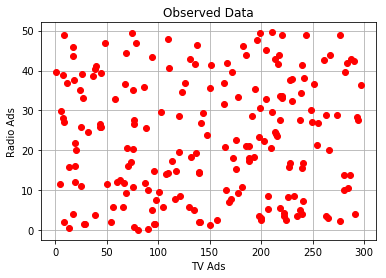

In [78]:
df = regression.getDataFrame()
plt.plot(df["TV"], df["Radio"], 'ro')
plt.xlabel('TV Ads')
plt.ylabel('Radio Ads')
plt.title('Observed Data')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

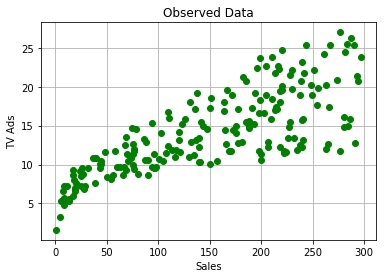

In [79]:
#X_new = regression.getDataFrame({'TV': [data.TV.min(), data.TV.max()]})
#X_new.head()
#min_max = [data.loc[df['TV'].idxmin(), "TV"], data.loc[df['TV'].idxmax(), "TV"]]
#feature_names = ["TV", "Radio"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

df = regression.getDataFrame()
plt.plot(df["TV"], df["Sales"], 'go')
plt.xlabel('Sales')
plt.ylabel('TV Ads')
plt.title('Observed Data')
plt.grid(True)
#plt.axis([0, 220, 0, 120])
plt.show()

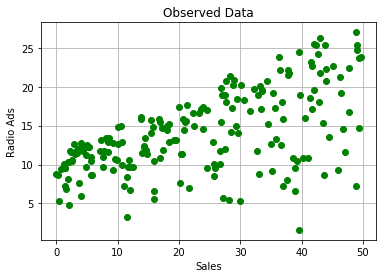

In [80]:
#X_new = regression.getDataFrame({'TV': [data.TV.min(), data.TV.max()]})
#X_new.head()

#selected_feature_names_attraction = ["Newspaper", "Radio"]
#fitted_production_model_attr = regression.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

df = regression.getDataFrame()
plt.plot(df["Radio"], df["Sales"], 'go')
plt.xlabel('Sales')
plt.ylabel('Radio Ads')
plt.title('Observed Data')
plt.grid(True)
#plt.axis([0, 220, 0, 120])
plt.show()

# MODEL FITTING

### Retreival of intercepts and coefficients
**Features for Trip production**: # of HH, # of HH members, # of employed, # of enrolled, Income, Landuse and Amenity Data

**Features for Trip attraction**: # of Establishments, # of working in area, # of enrolled in area, Landuse and Amenity Data

In [81]:
selected_feature_names = ["TV", "Radio"]
selected_feature_names_attraction = ["Newspaper", "Radio"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

dummy_data = pd.read_csv('DummyDemoData.csv', index_col=0)
dummy_data.head()

,Trips,no_Household,# Cars owned,no_HH_mem,Income,Employed in HH,Works_in,Establishments,Enrolled,Landuse_ind_1,Landuse_ind_2
1,5869,105,1,9,216290,3,1402,67,3,0,1
2,5708,66,1,4,231440,3,1997,70,8,1,1
3,2565,102,0,13,161121,1,3755,37,0,0,0
4,5412,78,4,14,177915,1,1234,41,9,0,0
5,3445,99,5,15,257947,3,1931,47,9,0,1


### Prediction of Trip Production & Attraction using the intercepts and coefficients

In [82]:
trip_gen = TripGeneration("Advertising.csv", "Sales")
prod_col_names = selected_feature_names
attr_col_names = selected_feature_names_attraction
trip_gen.setProductionParameters(prod_col_names, fitted_production_model.intercept_, fitted_production_model.coef_)
trip_gen.setAttractionParameters(attr_col_names, fitted_production_model_attr.intercept_, fitted_production_model_attr.coef_)
print("Example:")
print("Overall Trip Production: "+str(trip_gen.getWholeTripProductionScore()))
print("Overall Trip Attraction: "+str(trip_gen.getWholeTripAttractionScore()))

Example:
Overall Trip Production: 2804.5
Overall Trip Attraction: 2804.5


### Computing for Trip Balancing Factor

In [83]:
trip_gen.doTripBalancing()
print("Balancing Factor: "+str(trip_gen.getBalancingFactor()))


Balancing Factor: 1.0


### Zonal-level Trip Production & Attraction Scores

In [84]:
TEST_Y_TEST = trip_gen.printAllZonalTripsProductionAttraction()

Zone 1: Production=20.5554646334 , Attraction=17.1725829855
Zone 2: Production=12.3453622906 , Attraction=17.3110252703
Zone 3: Production=12.337017734 , Attraction=18.7855086135
Zone 4: Production=17.6171159596 , Attraction=17.7981463968
Zone 5: Production=13.2239081302 , Attraction=11.7266218654
Zone 6: Production=12.5120844855 , Attraction=19.42051419
Zone 7: Production=11.7182124139 , Attraction=15.8737212403
Zone 8: Production=12.1055155293 , Attraction=13.167266924
Zone 9: Production=3.70937919818 , Attraction=9.6135582809
Zone 10: Production=12.5516969588 , Attraction=9.84729290322
Zone 11: Production=7.03585970498 , Attraction=10.5041681273
Zone 12: Production=17.2565201535 , Attraction=13.9925674108
Zone 13: Production=10.6086618662 , Attraction=16.6132368061
Zone 14: Production=8.81095050707 , Attraction=10.7494974294
Zone 15: Production=18.4446677303 , Attraction=16.0431196265
Zone 16: Production=20.8289153929 , Attraction=19.0348244204
Zone 17: Production=12.9038650706 , At

# Model Validation

In [95]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
X_digits = regression.getSubTable(selected_feature_names)
Y_digits = regression.getSubTable(dep_col_name)
scores = cross_validation.cross_val_score(fitted_production_model, X_digits, Y_digits, scoring='r2', cv=10,)
#X_digits.shape, Y_digits.shape
scores

array([ 0.87936561,  0.85860496,  0.92960574,  0.89040105,  0.93302554,
        0.93129743,  0.76486772,  0.91373255,  0.83925519,  0.92951475])

# MODEL OUTPUT